In [1]:
import csv
import os
import pandas as pd
import numpy as np
import copy
import time
import pickle

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB, CategoricalNB


from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

import sklearn.model_selection as model_selection
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, det_curve
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Activation, GRU
from sklearn.preprocessing import normalize, LabelEncoder, MinMaxScaler

2022-09-06 10:31:58.389395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 10:31:58.389422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# usefull fucntions
def remove_nan_values(sample_array:np.array) -> np.array:
    for sample_index, i in enumerate(sample_array):
        for value_index, j in enumerate(i):
            if j==' ':
               sample_array[sample_index][value_index] = 0.0
            elif type(j) == str:
                sample_array[sample_index][value_index] = int(j)
            elif np.isnan(j):
               sample_array[sample_index][value_index] = 0.0
    return sample_array

def remove_1d_array_nan_values(sample_array: np.array, attack_categories: dict) -> np.array:
    for value_index, j in enumerate(sample_array):
        if j==' ':
           sample_array[value_index] = 0.0
        elif type(j) == str:
            try:
                sample_array[value_index] = int(j)
            except:
                sample_array[value_index] = attack_categories[j]
        elif np.isnan(j):
           sample_array[value_index] = 0.0
    return sample_array

def save_model(model, name, prefix) -> None:
    """Function responsible for saving trained model. It must be called
    after defining, training and predict.

    :param: None
    :return: None
    """

    filename = f"{name}_{prefix}.sav"
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filepath):
    """Function responsible for load model.

    :param: None
    :return: None
    """
    return pickle.load(open(filepath, 'rb'))

In [3]:
# load data to pandas DataFrame
df_path = '/home/mkubita/Pulpit/Praca Magisterska/Zbiory danych/TON_IoT/Train_Test_datasets/Train_Test_Network_dataset/Train_Test_Network.csv'
df = pd.read_csv(df_path, index_col=None, header=0)


In [7]:
df[df['label'] == 1].shape[0]

161043

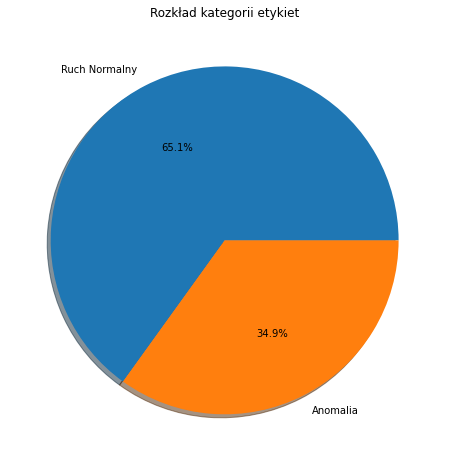

In [5]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii etykiet")
plt.pie([df[df['label'] == 0].shape[0], df[df['label'] == 1].shape[0]],
       labels=['Ruch Normalny', 'Anomalia'], autopct='%1.1f%%', shadow=True)
plt.show()

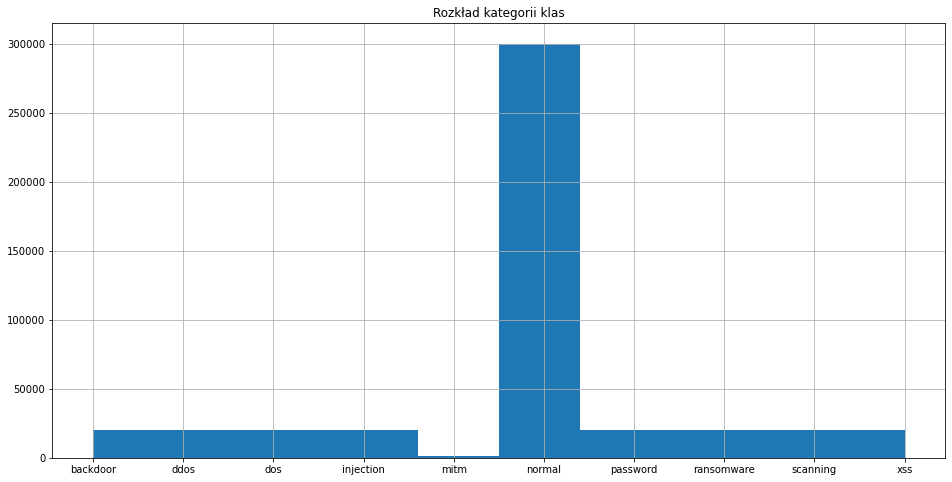

In [9]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.title("Rozkład kategorii klas")
plt.hist(df['type'].sort_values())
plt.show()

In [5]:
features = list(df.columns)

for i in ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'label', 'type']:
    features.remove(i)

In [6]:
# categorical features
cat_features = ['conn_state', 'proto', 'service', 'dns_query', 'ssl_version', 'ssl_cipher', 'ssl_subject', 'ssl_issuer', 'http_method', 'http_uri', 'http_version', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'http_user_agent', 'dns_rcode','dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_established', 'ssl_resumed', 'http_trans_depth']
for i in cat_features:
    encoder = LabelEncoder()
    df[i] = encoder.fit_transform(df[i])

### Binary classification

In [7]:
# prepare data for classification
df = df.dropna()

x = df[features].to_numpy()
y = df['label'].to_numpy()

# normalization min max
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [8]:
# split data
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y,
                                                                    train_size=0.80,
                                                                    test_size=0.20,
                                                                    random_state=101)

In [9]:
models = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)]

In [9]:
models_mlp = [MLPClassifier(hidden_layer_sizes=(50,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,30,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,50,20),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(200,100, 50, 25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(200,200,200),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(300,150,75),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [9]:
models_mlp_downsampling = [MLPClassifier(hidden_layer_sizes=(25,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,15,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(15,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(30,15, 5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(5,5,5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [10]:
for model in models_mlp_downsampling:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(30, 15, 5), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)

In [12]:
# train models
for model in models_mlp:
    model.fit(x_train, y_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 30, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 50, 20), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0

In [109]:
# train models
for model in models:
    model.fit(x_train, y_train)
    print(model)

GaussianNB()
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       random_state=10)
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       n_estimators=75, random_state=10)
MLPClassifier(hidden_layer_sizes=(15, 30, 60), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=11,
                                                         max_leaf_nodes=162,
                                                         min_impurity_decrease=6e-05,
                                                

In [121]:
x_train.shape

(368834, 39)

In [11]:
predictions = {i: None for i in models_mlp_downsampling}
for model, model_str in zip(models_mlp_downsampling, predictions):
    predictions[model_str] = model.predict(x_test)

In [111]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': ['NaiveBayes', 'DecisionTree', 'RandomForest', 'MultiLayerPercepton', 'AdaBoost', 'GradientBoost'],
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,NaiveBayes,72.8,56.2,99.6,71.8
1,DecisionTree,100.0,99.9,100.0,99.9
2,RandomForest,98.0,94.6,99.9,97.2
3,MultiLayerPercepton,97.3,93.4,99.4,96.3
4,AdaBoost,100.0,100.0,100.0,100.0
5,GradientBoost,100.0,100.0,100.0,100.0


In [14]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
#     fpr_score = det_curve(y_test, predictions[model_str])[0][1]
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
#     fpr_list.append(round(fpr_score, 3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': models_mlp,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(50,), learni...",97.2,93.4,98.9,96.1
1,"MLPClassifier(hidden_layer_sizes=(50, 50), lea...",97.1,92.7,99.4,95.9
2,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...",97.6,94.0,99.5,96.7
3,"MLPClassifier(hidden_layer_sizes=(50, 30, 10),...",97.4,93.3,99.5,96.3
4,"MLPClassifier(hidden_layer_sizes=(100, 100), l...",95.4,96.9,89.7,93.2
5,"MLPClassifier(hidden_layer_sizes=(100, 100, 10...",97.6,94.1,99.4,96.7
6,"MLPClassifier(hidden_layer_sizes=(100, 50, 20)...",97.1,92.7,99.5,95.9
7,"MLPClassifier(hidden_layer_sizes=(200, 100, 50...",97.3,93.5,99.2,96.2
8,"MLPClassifier(hidden_layer_sizes=(200, 200, 20...",97.3,93.4,99.4,96.3
9,"MLPClassifier(hidden_layer_sizes=(300, 150, 75...",96.8,92.2,99.3,95.6


In [12]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp_downsampling, predictions):
    accuracy = accuracy_score(y_test, predictions[model_str])
    precision = precision_score(y_test, predictions[model_str], average='binary')
    recall = recall_score(y_test, predictions[model_str], average='binary')
    f1_ = f1_score(y_test, predictions[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)


results = {'Model': models_mlp_downsampling,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(25,), learni...",96.8,93.3,97.9,95.5
1,"MLPClassifier(hidden_layer_sizes=(25, 25), lea...",97.2,93.3,99.2,96.2
2,"MLPClassifier(hidden_layer_sizes=(25, 25, 25),...",97.3,93.2,99.4,96.2
3,"MLPClassifier(hidden_layer_sizes=(25, 15, 10),...",97.1,93.0,99.0,95.9
4,"MLPClassifier(hidden_layer_sizes=(15,), learni...",96.8,92.4,99.0,95.6
5,"MLPClassifier(hidden_layer_sizes=(15, 15), lea...",97.4,93.5,99.3,96.3
6,"MLPClassifier(hidden_layer_sizes=(15, 15, 15),...",97.6,94.4,99.1,96.7
7,"MLPClassifier(hidden_layer_sizes=(30, 15, 5), ...",97.1,93.1,98.9,95.9
8,"MLPClassifier(hidden_layer_sizes=(5, 5, 5), le...",96.4,91.9,98.4,95.1


In [13]:
predictions = {i: None for i in models_mlp}
for model, model_str in zip(models_mlp, predictions):
    predictions[model_str] = model.predict(x_test)

In [ ]:
# Sprawdzic architektury MLP z mniejsza iloscia parametrów (downsampling)

# AdaBoost, GBT -> testy

# Inne zbiory danych


# wazny element pracy -> dobrze opisany zbior danych
# za tydzien piatek 11:30 24.06



In [124]:
model = Sequential()

model.add(LSTM(300, activation="tanh", return_sequences = True, input_shape = (39, 1)))
model.add(Dropout(0.4))

model.add(LSTM(200, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(100, activation="tanh", return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(80, activation="tanh"))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-06-07 00:02:46.669755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 00:02:46.670311: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 00:02:46.670415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-07 00:02:46.670498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-07 00:02:46.695391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [125]:
model.fit(x_train, y_train, batch_size=64, 
          epochs=20, validation_data=(x_test, y_test))


Epoch 1/20
5764/5764 [==============================] - 1059s 183ms/step - loss: 0.4214 - accuracy: 0.7530 - val_loss: 0.4253 - val_accuracy: 0.7012
Epoch 2/20
5764/5764 [==============================] - 1034s 179ms/step - loss: 0.3672 - accuracy: 0.8082 - val_loss: 0.5352 - val_accuracy: 0.6518
Epoch 3/20
5764/5764 [==============================] - 1085s 188ms/step - loss: 0.3649 - accuracy: 0.8029 - val_loss: 0.4680 - val_accuracy: 0.6724
Epoch 4/20
5764/5764 [==============================] - 1127s 196ms/step - loss: 0.2619 - accuracy: 0.8824 - val_loss: 0.1809 - val_accuracy: 0.9201
Epoch 5/20
5764/5764 [==============================] - 1195s 207ms/step - loss: 0.2678 - accuracy: 0.8700 - val_loss: 0.2246 - val_accuracy: 0.8881
Epoch 6/20
5764/5764 [==============================] - 1217s 211ms/step - loss: 0.2341 - accuracy: 0.8869 - val_loss: 0.1487 - val_accuracy: 0.9583
Epoch 7/20
5764/5764 [==============================] - 1219s 211ms/step - loss: 0.2149 - accuracy: 0.9064

In [126]:
prediction_lstm = model.predict(x_test)
prediction_lstm = prediction_lstm.flatten()
prediction_lstm = [int(round(i,0)) for i in prediction_lstm]

accuracy = accuracy_score(y_test, prediction_lstm)
precision = precision_score(y_test, prediction_lstm, average='binary')
recall = recall_score(y_test, prediction_lstm, average='binary')
f1_ = f1_score(y_test, prediction_lstm, average='binary')

print(accuracy, precision, recall, f1_)

0.964331030593543 0.9276747291883068 0.9734662099034569 0.9500189955170579


In [9]:
model_GRU = Sequential()

model_GRU.add(GRU(300, activation="tanh", return_sequences = True, input_shape = (39, 1)))
model_GRU.add(Dropout(0.4))

model_GRU.add(GRU(200, activation="tanh", return_sequences = True))
model_GRU.add(Dropout(0.4))

model_GRU.add(GRU(100, activation="tanh", return_sequences = True))
model_GRU.add(Dropout(0.4))

model_GRU.add(GRU(80, activation="tanh"))
model_GRU.add(Dropout(0.4))

model_GRU.add(Dense(1))
model_GRU.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-06-07 09:22:27.441232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 09:22:27.441581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 09:22:27.441644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-07 09:22:27.441699: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-07 09:22:27.468290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [10]:
model_GRU.fit(x_train, y_train, batch_size=64, 
          epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
5764/5764 [==============================] - 1009s 174ms/step - loss: 0.2773 - accuracy: 0.8680 - val_loss: 0.2482 - val_accuracy: 0.8810
Epoch 2/20
5764/5764 [==============================] - 1070s 186ms/step - loss: 0.1640 - accuracy: 0.9324 - val_loss: 0.1240 - val_accuracy: 0.9491
Epoch 3/20
5764/5764 [==============================] - 1022s 177ms/step - loss: 0.1224 - accuracy: 0.9532 - val_loss: 0.3028 - val_accuracy: 0.8785
Epoch 4/20
5764/5764 [==============================] - 1104s 192ms/step - loss: 0.1829 - accuracy: 0.9287 - val_loss: 0.1325 - val_accuracy: 0.9567
Epoch 5/20
5764/5764 [==============================] - 1098s 190ms/step - loss: 0.1669 - accuracy: 0.9346 - val_loss: 0.1297 - val_accuracy: 0.9444
Epoch 6/20
5764/5764 [==============================] - 1115s 194ms/step - loss: 0.1689 - accuracy: 0.9318 - val_loss: 0.1907 - val_accuracy: 0.8768
Epoch 7/20
5764/5764 [==============================] - 1119s 194ms/step - loss: 0.1453 - accuracy: 0.9452

In [12]:
prediction_gru = model_GRU.predict(x_test)
prediction_gru = prediction_gru.flatten()
prediction_gru = [int(round(i,0)) for i in prediction_gru]

accuracy = accuracy_score(y_test, prediction_gru)
precision = precision_score(y_test, prediction_gru, average='binary')
recall = recall_score(y_test, prediction_gru, average='binary')
f1_ = f1_score(y_test, prediction_gru, average='binary')

print(accuracy, precision, recall, f1_)

0.9238469129911397 0.8411105672485996 0.9632824665213329 0.8980605075198885


## Reduced Features

In [13]:
reduced_features = ['ts', 'proto', 'src_ip_bytes', 'src_pkts', 'dst_ip_bytes', 'dst_pkts', 'conn_state', 'dst_bytes', 'src_bytes', 'duration']

In [14]:
# prepare data for classification

x_reduced = df[features][reduced_features].to_numpy()
y_reduced = df['label'].to_numpy()

In [15]:
# normalization min max
scaler = MinMaxScaler()
x_reduced = scaler.fit_transform(x_reduced)

In [16]:
# split data
x_reduced_train, x_reduced_test, y_reduced_train, y_reduced_test = model_selection.train_test_split(x_reduced, y_reduced,
                                                                    train_size=0.80,
                                                                    test_size=0.20,
                                                                    random_state=101)

In [17]:
models_reduced = [GaussianNB(), 
          DecisionTreeClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2),
          RandomForestClassifier(criterion="entropy",
                                 class_weight="balanced",
                                 random_state=10,
                                 max_depth=20,
                                 max_leaf_nodes=162,
                                 min_samples_leaf=20,
                                 min_impurity_decrease=0.00006,
                                 min_samples_split=2,
                                 n_estimators=75),
          MLPClassifier(hidden_layer_sizes=(15,30,60),
                        solver="adam",
                        activation="relu",
                        learning_rate_init=0.002,
                        learning_rate="adaptive",
                        max_iter=2000
                       ),
          AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='gini',
                                                                   random_state=10,
                                                                   class_weight='balanced',
                                                                   max_depth=11,
                                                                   max_leaf_nodes=162,
                                                                   min_samples_leaf=20,
                                                                   min_impurity_decrease=0.00006),
                            n_estimators=3300,
                            learning_rate=0.3,
                            algorithm='SAMME.R'),
         GradientBoostingClassifier(loss='deviance',
                                   n_estimators=3200,
                                   learning_rate=0.05)]

In [14]:
models_mlp = [MLPClassifier(hidden_layer_sizes=(50,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,50,50),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(50,30,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,100,100),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(100,50,20),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(200,100, 50, 25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(200,200,200),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(300,150,75),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [17]:
models_mlp_downsampling = [MLPClassifier(hidden_layer_sizes=(25,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,25,25),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(25,15,10),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(15,),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(15,15,15),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
             MLPClassifier(hidden_layer_sizes=(30,15, 5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               ),
            MLPClassifier(hidden_layer_sizes=(5,5,5),
                solver="adam",
                activation="relu",
                learning_rate_init=0.002,
                learning_rate="adaptive",
                max_iter=2000
               )
             ]

In [18]:
# train models
for model in models_mlp_downsampling:
    model.fit(x_reduced_train, y_reduced_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(25,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 25, 25), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(25, 15, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(15, 15, 15), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(30, 15, 5), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)

In [15]:
# train models
for model in models_mlp:
    model.fit(x_reduced_train, y_reduced_train)
    print(model)

MLPClassifier(hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(50, 30, 10), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 100, 100), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(100, 50, 20), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
MLPClassifier(hidden_layer_sizes=(200, 100, 50, 25), learning_rate='adaptive',
              learning_rate_init=0

In [16]:
predictions_2 = {i: None for i in models_mlp}
for model, model_str in zip(models_mlp, predictions_2):
    predictions_2[model_str] = model.predict(x_reduced_test)

In [117]:
# train models
for model in models_reduced:
    model.fit(x_reduced_train, y_reduced_train)
    print(model)

GaussianNB()
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       random_state=10)
RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_leaf_nodes=162,
                       min_impurity_decrease=6e-05, min_samples_leaf=20,
                       n_estimators=75, random_state=10)
MLPClassifier(hidden_layer_sizes=(15, 30, 60), learning_rate='adaptive',
              learning_rate_init=0.002, max_iter=2000)
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=11,
                                                         max_leaf_nodes=162,
                                                         min_impurity_decrease=6e-05,
                                                

In [118]:
predictions_2 = {i: None for i in models_reduced}
for model, model_str in zip(models_reduced, predictions_2):
    predictions_2[model_str] = model.predict(x_reduced_test)

In [19]:


predictions_2 = {i: None for i in models_mlp_downsampling}
for model, model_str in zip(models_mlp_downsampling, predictions_2):
    predictions_2[model_str] = model.predict(x_reduced_test)

In [120]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_reduced, predictions_2):
    accuracy = accuracy_score(y_reduced_test, predictions_2[model_str])
    precision = precision_score(y_reduced_test, predictions_2[model_str], average='binary')
    recall = recall_score(y_reduced_test, predictions_2[model_str], average='binary')
    f1_ = f1_score(y_reduced_test, predictions_2[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': ['NaiveBayes', 'DecisionTree', 'RandomForest', 'MultiLayerPercepton', 'AdaBoost', 'GradientBoost'],
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,NaiveBayes,87.3,75.7,93.5,83.6
1,DecisionTree,99.9,99.9,100.0,99.9
2,RandomForest,99.8,99.6,99.8,99.7
3,MultiLayerPercepton,96.8,92.9,98.3,95.5
4,AdaBoost,100.0,100.0,100.0,100.0
5,GradientBoost,100.0,100.0,100.0,100.0


In [17]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp, predictions_2):
    accuracy = accuracy_score(y_reduced_test, predictions_2[model_str])
    precision = precision_score(y_reduced_test, predictions_2[model_str], average='binary')
    recall = recall_score(y_reduced_test, predictions_2[model_str], average='binary')
    f1_ = f1_score(y_reduced_test, predictions_2[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': models_mlp,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(50,), learni...",95.8,90.8,98.0,94.3
1,"MLPClassifier(hidden_layer_sizes=(50, 50), lea...",97.0,93.4,98.4,95.8
2,"MLPClassifier(hidden_layer_sizes=(50, 50, 50),...",97.1,93.8,98.2,95.9
3,"MLPClassifier(hidden_layer_sizes=(50, 30, 10),...",92.1,82.0,99.0,89.7
4,"MLPClassifier(hidden_layer_sizes=(100, 100), l...",96.9,93.2,98.2,95.7
5,"MLPClassifier(hidden_layer_sizes=(100, 100, 10...",96.6,92.4,98.3,95.3
6,"MLPClassifier(hidden_layer_sizes=(100, 50, 20)...",94.4,87.2,98.3,92.4
7,"MLPClassifier(hidden_layer_sizes=(200, 100, 50...",96.3,91.6,98.3,94.8
8,"MLPClassifier(hidden_layer_sizes=(200, 200, 20...",92.7,94.1,84.2,88.9
9,"MLPClassifier(hidden_layer_sizes=(300, 150, 75...",92.5,94.3,83.4,88.5


In [21]:
# accuracy
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
# fpr_list = []
for model, model_str in zip(models_mlp_downsampling, predictions_2):
    accuracy = accuracy_score(y_reduced_test, predictions_2[model_str])
    precision = precision_score(y_reduced_test, predictions_2[model_str], average='binary')
    recall = recall_score(y_reduced_test, predictions_2[model_str], average='binary')
    f1_ = f1_score(y_reduced_test, predictions_2[model_str], average='binary')
    
    accuracy_list.append(round(accuracy, 3) * 100)
    precision_list.append(round(precision,3) * 100)
    recall_list.append(round(recall,3) * 100)
    f1_list.append(round(f1_,3) * 100)

# accuracy_list[3] = 83.9
# precision_list[3] = 82.4

# accuracy_list.append(86.6)
# accuracy_list.append(86.6)
# precision_list.append(81.3)
# recall_list.append(98.5)
# f1_list.append(89.1)
# precision_list.append(78.2)
# recall_list.append(99.2)
# f1_list.append(87.5)

results = {'Model': models_mlp_downsampling,
           'Accuracy [%]': accuracy_list,
           'Precision [%]': precision_list,
           'Recall [%]': recall_list,
           'F1_score [%]': f1_list,
#            'FPR_score [%]': fpr_list
          }
 
# Convert the dictionary into DataFrame 
result_metrics = pd.DataFrame(results)
result_metrics

,Model,Accuracy [%],Precision [%],Recall [%],F1_score [%]
0,"MLPClassifier(hidden_layer_sizes=(25,), learni...",95.7,90.3,98.0,94.0
1,"MLPClassifier(hidden_layer_sizes=(25, 25), lea...",96.9,93.3,98.3,95.7
2,"MLPClassifier(hidden_layer_sizes=(25, 25, 25),...",96.8,93.1,98.1,95.6
3,"MLPClassifier(hidden_layer_sizes=(25, 15, 10),...",96.9,93.2,98.3,95.7
4,"MLPClassifier(hidden_layer_sizes=(15,), learni...",93.7,94.3,87.1,90.6
5,"MLPClassifier(hidden_layer_sizes=(15, 15), lea...",96.6,97.1,93.1,95.1
6,"MLPClassifier(hidden_layer_sizes=(15, 15, 15),...",97.3,96.8,95.3,96.0
7,"MLPClassifier(hidden_layer_sizes=(30, 15, 5), ...",96.8,92.9,98.3,95.5
8,"MLPClassifier(hidden_layer_sizes=(5, 5, 5), le...",87.0,75.2,93.5,83.3


In [13]:
model2 = Sequential()

model2.add(LSTM(300, activation="tanh", return_sequences = True, input_shape = (10, 1)))
model2.add(Dropout(0.4))

model2.add(LSTM(200, activation="tanh", return_sequences = True))
model2.add(Dropout(0.4))

model2.add(LSTM(100, activation="tanh", return_sequences = True))
model2.add(Dropout(0.4))

model2.add(LSTM(80, activation="tanh"))
model2.add(Dropout(0.4))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2022-06-07 18:55:56.176668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-07 18:55:56.177032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 18:55:56.177101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-07 18:55:56.177160: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-07 18:55:56.197804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [14]:
model2.fit(x_reduced_train, y_reduced_train, batch_size=64, 
          epochs=20, validation_data=(x_reduced_test, y_reduced_test))


Epoch 1/20
5764/5764 [==============================] - 320s 55ms/step - loss: 0.2869 - accuracy: 0.8644 - val_loss: 0.2589 - val_accuracy: 0.8711
Epoch 2/20
5764/5764 [==============================] - 319s 55ms/step - loss: 0.2633 - accuracy: 0.8713 - val_loss: 0.2600 - val_accuracy: 0.9015
Epoch 3/20
5764/5764 [==============================] - 323s 56ms/step - loss: 0.2525 - accuracy: 0.8734 - val_loss: 0.1842 - val_accuracy: 0.8858
Epoch 4/20
5764/5764 [==============================] - 332s 58ms/step - loss: 0.2428 - accuracy: 0.8739 - val_loss: 0.1838 - val_accuracy: 0.9013
Epoch 5/20
5764/5764 [==============================] - 315s 55ms/step - loss: 0.2147 - accuracy: 0.8910 - val_loss: 0.1563 - val_accuracy: 0.9220
Epoch 6/20
5764/5764 [==============================] - 315s 55ms/step - loss: 0.1869 - accuracy: 0.9074 - val_loss: 0.3346 - val_accuracy: 0.8716
Epoch 7/20
5764/5764 [==============================] - 317s 55ms/step - loss: 0.2280 - accuracy: 0.8867 - val_loss: 0

In [15]:
prediction2 = model2.predict(x_reduced_test)
prediction2 = prediction2.flatten()
prediction2 = [int(round(i,0)) for i in prediction2]

accuracy = accuracy_score(y_reduced_test, prediction2)
precision = precision_score(y_reduced_test, prediction2, average='binary')
recall = recall_score(y_reduced_test, prediction2, average='binary')
f1_ = f1_score(y_reduced_test, prediction2, average='binary')

print(accuracy, precision, recall, f1_)

0.8757713455302628 0.7533423279774316 0.9563998754282155 0.8428130360205832


In [16]:
model_GRU2 = Sequential()

model_GRU2.add(GRU(300, activation="tanh", return_sequences = True, input_shape = (10, 1)))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(GRU(200, activation="tanh", return_sequences = True))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(GRU(100, activation="tanh", return_sequences = True))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(GRU(80, activation="tanh"))
model_GRU2.add(Dropout(0.4))

model_GRU2.add(Dense(1))
model_GRU2.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model_GRU2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model_GRU2.fit(x_reduced_train, y_reduced_train, batch_size=64, 
          epochs=20, validation_data=(x_reduced_test, y_reduced_test))


Epoch 1/20
5764/5764 [==============================] - 278s 47ms/step - loss: 0.2723 - accuracy: 0.8735 - val_loss: 0.1480 - val_accuracy: 0.9571
Epoch 2/20
5764/5764 [==============================] - 274s 47ms/step - loss: 0.1601 - accuracy: 0.9328 - val_loss: 0.0948 - val_accuracy: 0.9670
Epoch 3/20
5764/5764 [==============================] - 278s 48ms/step - loss: 0.1256 - accuracy: 0.9491 - val_loss: 0.1671 - val_accuracy: 0.9411
Epoch 4/20
5764/5764 [==============================] - 303s 53ms/step - loss: 0.1628 - accuracy: 0.9384 - val_loss: 0.1168 - val_accuracy: 0.9589
Epoch 5/20
5764/5764 [==============================] - 302s 52ms/step - loss: 0.1575 - accuracy: 0.9385 - val_loss: 0.3414 - val_accuracy: 0.8685
Epoch 6/20
5764/5764 [==============================] - 302s 52ms/step - loss: 0.2393 - accuracy: 0.8849 - val_loss: 0.2939 - val_accuracy: 0.8728
Epoch 7/20
5764/5764 [==============================] - 292s 51ms/step - loss: 0.2606 - accuracy: 0.8775 - val_loss: 0

In [18]:
prediction_gru2 = model_GRU2.predict(x_reduced_test)
prediction_gru2 = prediction_gru2.flatten()
prediction_gru2 = [int(round(i,0)) for i in prediction_gru2]

accuracy = accuracy_score(y_reduced_test, prediction_gru2)
precision = precision_score(y_reduced_test, prediction_gru2, average='binary')
recall = recall_score(y_reduced_test, prediction_gru2, average='binary')
f1_ = f1_score(y_reduced_test, prediction_gru2, average='binary')

print(accuracy, precision, recall, f1_)

0.8873971087420968 0.7596624997012215 0.9897851136717534 0.859588624284961
